In [1]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt
import helper

In [2]:

num_trials = 10
model_names = ['task2-cnn-shallow', 'task2-cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear']

results_path = os.path.join('../results', 'synthetic_code')
params_path = os.path.join(results_path, 'params')
save_path = os.path.join('..', 'scores')

In [3]:

# load data
data_path = '../data/Synthetic_code_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]
X_model = test_model[true_index][:500]

In [73]:
score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']

activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear']
all_scores = {}
for model_name in model_names:
    for activation in activations:
        name = model_name+'_'+activation
        print(name)

        file_path = os.path.join(save_path, name+'.pickle')
        with open(file_path, 'rb') as f:            
            saliency_scores1 = cPickle.load(f)
            saliency_scores2 = cPickle.load(f)
            mut_scores1 = cPickle.load(f)
            mut_scores2 = cPickle.load(f)
            smoothgrad_scores = cPickle.load(f)
            integrated_scores = cPickle.load(f)

        file_path = os.path.join(save_path, name+'_shap.pickle')
        with open(file_path, 'rb') as f:
            shap_scores = cPickle.load(f)

        model_scores = [saliency_scores1[0], mut_scores1[0], 
                      smoothgrad_scores[0], integrated_scores[0], 
                      shap_scores[0]]
        scores = []
        for score, score_name in zip(model_scores, score_names):
            if 'mut' in score_name:
                scores.append(np.sqrt(np.sum(score**2, axis=-1, keepdims=True)) * X)
            else:
                scores.append(score * X)
        all_scores[name] = np.array(scores)

    

task2-cnn-shallow_relu
task2-cnn-shallow_exponential
task2-cnn-shallow_sigmoid
task2-cnn-shallow_tanh
task2-cnn-shallow_softplus
task2-cnn-shallow_linear
task2-cnn-deep_relu
task2-cnn-deep_exponential
task2-cnn-deep_sigmoid
task2-cnn-deep_tanh
task2-cnn-deep_softplus
task2-cnn-deep_linear


In [4]:
import logomaker
import pandas as pd

In [5]:

# save results
file_path = os.path.join(results_path, 'attr_results.pickle')
with open(file_path, 'rb') as f:
    results = cPickle.load(f)
    

In [7]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score
      
def interpretability_performance(X, score, X_model):

    score = np.sum(score, axis=2)
    pr_score = []
    roc_score = []
    for j, gs in enumerate(score):

        # calculate information of ground truth
        gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

        # set label if information is greater than 0
        label = np.zeros(gt_info.shape)
        label[gt_info > 0.01] = 1

        # precision recall metric
        precision, recall, thresholds = precision_recall_curve(label, gs)
        pr_score.append(auc(recall, precision))

        # roc curve
        fpr, tpr, thresholds = roc_curve(label, gs)
        roc_score.append(auc(fpr, tpr))

    roc_score = np.array(roc_score)
    pr_score = np.array(pr_score)
    return roc_score, pr_score
    

# compare relu and exp

In [12]:
from tfomics import utils
plot_path = utils.make_directory(results_path, 'attr_plots_new')

making directory: ../results/synthetic_code/attr_plots_new


Using TensorFlow backend.


In [70]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-deep_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]

score_name = 'saliency'
names = ['ReLU', 'Exp', 'ReLU', 'Exp']

N, L, A = x_test.shape
for index in sort_index[:50]:
    print(index)
    x = np.ones((4,L,A))*X[index]
    x_model = np.ones((4,A,L))*X_model[index]

    scores = []
    scores.append(all_scores['task2-cnn-shallow_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][0,index,:,:])
    scores = np.array(scores)
    
    roc_score, pr_score = interpretability_performance(x, scores, x_model)
   
    fig = plt.figure(figsize=(25,9))
    # plot in silico mutagenesis for sequences with top predictions
    N, L, A = X.shape
    for k in range(4):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(5,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(5,1,5)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])

    outfile = os.path.join(plot_path, 'task2_compare_attr_logo_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    


332
251
138
455
477
175
185
181
242
441
247
417
499
48
257
442
429
314
409
4
76
171
227
176
152
420
34
111
305
97
312
283
119
362
123
61
38
486
350
376
427
147
428
36
284
302
367
263
478
363


# compare different methods

In [75]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-shallow_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]


names = ['Relu', 'Exp', 'Sigmoid', 'Tanh', 'Softplus', 'Linear']

score_name = 'saliency'
for index in sort_index[:50]:
    print(index)
    x = np.ones((len(activations),L,A))*X[index]
    x_model = np.ones((len(activations),A,L))*X_model[index]

    scores = []
    scores.append(all_scores['task2-cnn-shallow_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_tanh'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_softplus'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_linear'][0,index,:,:])
    scores = np.array(scores)
    
    roc_score, pr_score = interpretability_performance(x, scores, x_model)
   
    fig = plt.figure(figsize=(25,10))
    N, L, A = X.shape
    for k in range(len(names)):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(len(names)+1,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(len(names)+1,1,len(names)+1)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])

    outfile = os.path.join(plot_path, 'cnn-shallow_task2_logo_activations_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    


152
128
387
225
247
436
51
139
176
52
487
427
333
498
6
488
483
224
437
135
477
499
90
123
281
364
100
48
13
45
329
93
1
34
443
470
465
65
455
375
172
46
486
376
231
263
207
433
313
58


In [76]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-deep_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]


names = ['Relu', 'Exp', 'Sigmoid', 'Tanh', 'Softplus', 'Linear']

score_name = 'saliency'
for index in sort_index[:50]:
    print(index)
    x = np.ones((len(activations),L,A))*X[index]
    x_model = np.ones((len(activations),A,L))*X_model[index]

    scores = []
    scores.append(all_scores['task2-cnn-deep_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_tanh'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_softplus'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_linear'][0,index,:,:])
    scores = np.array(scores)
    
    roc_score, pr_score = interpretability_performance(x, scores, x_model)
   
    fig = plt.figure(figsize=(25,10))
    N, L, A = X.shape
    for k in range(len(names)):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(len(names)+1,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(len(names)+1,1,len(names)+1)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])

    outfile = os.path.join(plot_path, 'cnn-deep_task2_logo_activations_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    


332
251
138
455
477
175
185
181
242
441
247
417
499
48
257
442
429
314
409
4
76
171
227
176
152
420
34
111
305
97
312
283
119
362
123
61
38
486
350
376
427
147
428
36
284
302
367
263
478
363


# example other activation functions


In [80]:

num_trials = 10
model_names = ['task2-cnn-shallow', 'task2-cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['relu', 'exponential', 'sigmoid', 'tanh', 
               'exp_relu', 'shift_scale_tanh', 'shift_scale_relu', 'shift_scale_sigmoid']

results_path = os.path.join('../results', 'synthetic_code')
params_path = os.path.join(results_path, 'params')
save_path = os.path.join('..', 'scores')

In [81]:
score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']

all_scores = {}
for model_name in model_names:
    for activation in activations:
        name = model_name+'_'+activation
        print(name)

        file_path = os.path.join(save_path, name+'.pickle')
        with open(file_path, 'rb') as f:            
            scores = cPickle.load(f)
            
        scores *= X
        
        all_scores[name] = scores

    

task2-cnn-shallow_relu
task2-cnn-shallow_exponential
task2-cnn-shallow_sigmoid
task2-cnn-shallow_tanh
task2-cnn-shallow_exp_relu
task2-cnn-shallow_shift_scale_tanh
task2-cnn-shallow_shift_scale_relu
task2-cnn-shallow_shift_scale_sigmoid
task2-cnn-deep_relu
task2-cnn-deep_exponential
task2-cnn-deep_sigmoid
task2-cnn-deep_tanh
task2-cnn-deep_exp_relu
task2-cnn-deep_shift_scale_tanh
task2-cnn-deep_shift_scale_relu
task2-cnn-deep_shift_scale_sigmoid


10


IndexError: list index out of range

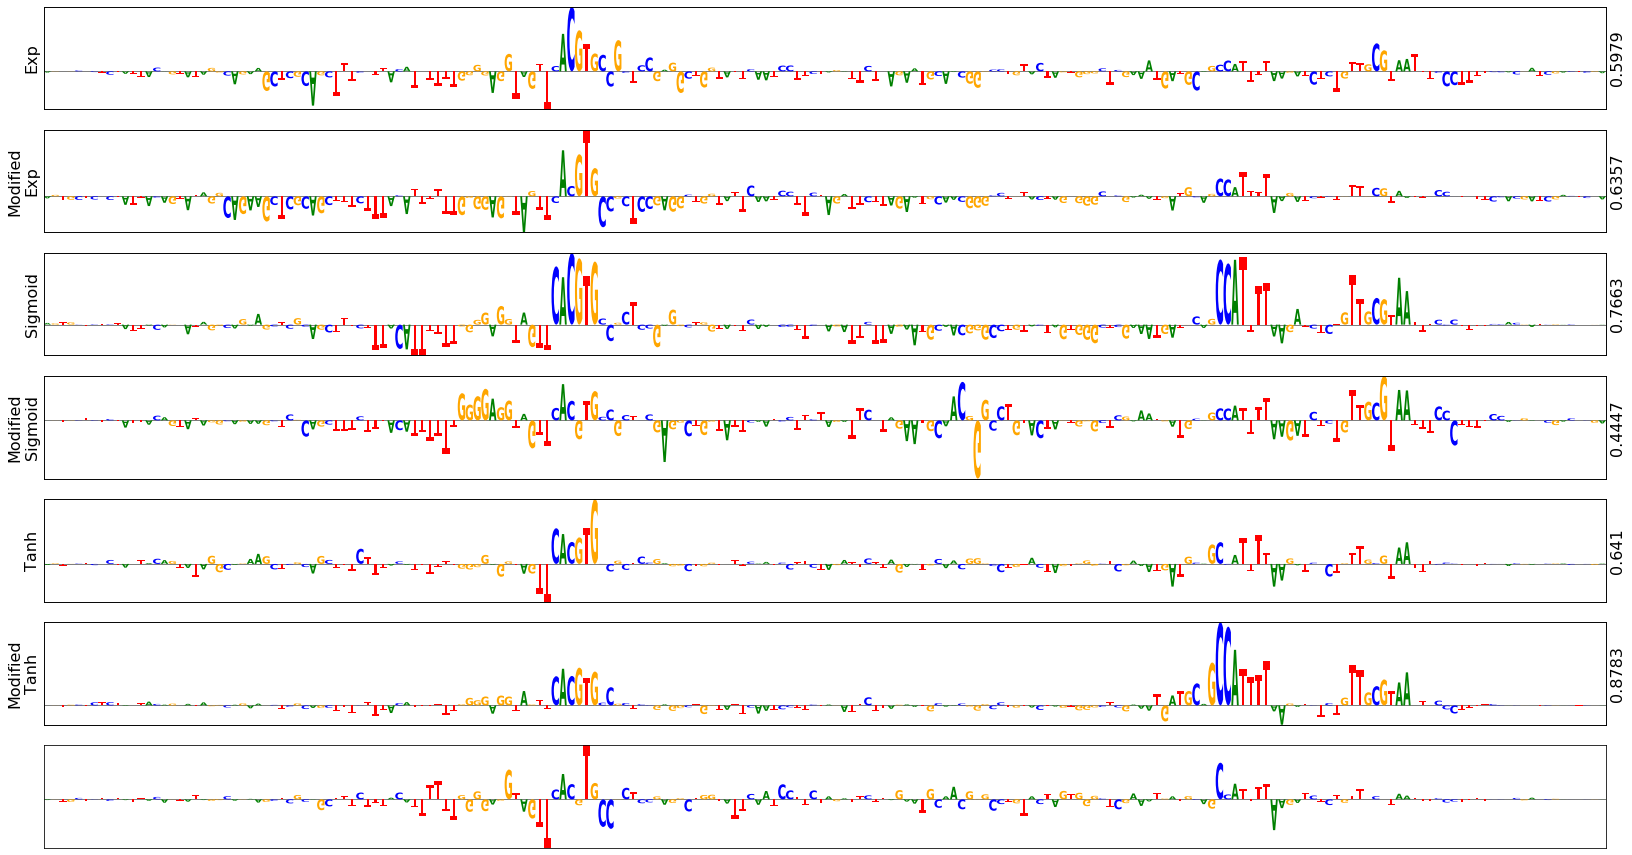

In [82]:

index = 10
activations = ['exponential', 'exp_relu', 'sigmoid', 'shift_scale_sigmoid', 'tanh', 'shift_scale_tanh']

names = ['\nExp', 'Modified\nExp', '\nSigmoid', 'Modified\nSigmoid', 'Tanh', 'Modified\nTanh' ]

print(index)
x = np.ones((8,L,A))*X[index]
x_model = np.ones((8,A,L))*X_model[index]

scores = []
scores.append(all_scores['task2-cnn-deep_relu'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_shift_scale_relu'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_exponential'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_exp_relu'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_sigmoid'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_shift_scale_sigmoid'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_tanh'][0,index,:,:])
scores.append(all_scores['task2-cnn-deep_shift_scale_tanh'][0,index,:,:])
scores = np.array(scores)

roc_score, pr_score = interpretability_performance(x, scores, x_model)

fig = plt.figure(figsize=(28,20))
# plot in silico mutagenesis for sequences with top predictions
N, L, A = X.shape
for k in range(8):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = scores[k,l,a]

    ax = plt.subplot(9,1,k+1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    plt.ylabel(names[k], fontsize=16)
    ax2 = ax.twinx()
    plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])

counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
w = X_model[index].T
I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
logo = I*w
for a in range(A):
    for l in range(L):
        counts_df.iloc[l,a] = logo[l,a]

ax = plt.subplot(9,1,9)
logomaker.Logo(counts_df, ax=ax)
plt.ylabel('Truth', fontsize=16)
ax = plt.gca()
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xticks([])
plt.yticks([]);

In [83]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-deep_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]


activations = ['exponential', 'exp_relu', 'sigmoid', 'shift_scale_sigmoid', 'tanh', 'shift_scale_tanh']

names = ['\nExp', 'Modified\nExp', '\nSigmoid', 'Modified\nSigmoid', 'Tanh', 'Modified\nTanh' ]

N, L, A = x_test.shape
for index in sort_index[:50]:
    print(index)
    
    x = np.ones((6,L,A))*X[index]
    x_model = np.ones((6,A,L))*X_model[index]

    scores = []
    #scores.append(all_scores['task2-cnn-deep_relu'][0,index,:,:])
    #scores.append(all_scores['task2-cnn-deep_shift_scale_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exp_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_shift_scale_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_tanh'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_shift_scale_tanh'][0,index,:,:])
    scores = np.array(scores)

    roc_score, pr_score = interpretability_performance(x, scores, x_model)

    fig = plt.figure(figsize=(28,16))
    # plot in silico mutagenesis for sequences with top predictions
    N, L, A = X.shape
    for k in range(6):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(7,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(7,1,7)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([]);

    outfile = os.path.join(plot_path, 'cnn-deep_activations_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    


332
251
138
455
477
175
185
181
242
441
247
417
499
48
257
442
429
314
409
4
76
171
227
176
152
420
34
111
305
97
312
283
119
362
123
61
38
486
350
376
427
147
428
36
284
302
367
263
478
363


In [84]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-shallow_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]

activations = ['relu', 'exponential', 'sigmoid', 'tanh', 
               'exp_relu', 'shift_scale_tanh', 'shift_scale_relu', 'shift_scale_sigmoid']

names = ['\nExp', 'Modified\nExp', '\nSigmoid', 'Modified\nSigmoid', 'Tanh', 'Modified\nTanh' ]


N, L, A = x_test.shape
for index in sort_index[:50]:
    print(index)
    
    x = np.ones((6,L,A))*X[index]
    x_model = np.ones((86,A,L))*X_model[index]

    scores = []
    #scores.append(all_scores['task2-cnn-shallow_relu'][0,index,:,:])
    #scores.append(all_scores['task2-cnn-shallow_shift_scale_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_exp_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_shift_scale_sigmoid'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_tanh'][0,index,:,:])
    scores.append(all_scores['task2-cnn-shallow_shift_scale_tanh'][0,index,:,:])
    scores = np.array(scores)

    roc_score, pr_score = interpretability_performance(x, scores, x_model)

    fig = plt.figure(figsize=(28,16))
    # plot in silico mutagenesis for sequences with top predictions
    N, L, A = X.shape
    for k in range(6):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(9,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(7,1,7)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([]);

    outfile = os.path.join(plot_path, 'cnn-shallow_activations_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    


152
128
387
225
247
436
51
139
176
52
487
427
333
498
6
488
483
224
437
135
477
499
90
123
281
364
100
48
13
45
329
93
1
34
443
470
465
65
455
375
172
46
486
376
231
263
207
433
313
58


# compare attribution methods

In [56]:
score_names = ['saliency_scores1', 'mut_scores1', 'integrated_scores', 'shap_scores']
activations = ['relu', 'exponential']#, 'sigmoid', 'tanh', 'softplus', 'linear']


all_scores = {}
for model_name in model_names:
    for activation in activations:
        name = model_name+'_'+activation
        print(name)

        file_path = os.path.join(save_path, name+'.pickle')
        with open(file_path, 'rb') as f:            
            saliency_scores1 = cPickle.load(f)
            saliency_scores2 = cPickle.load(f)
            mut_scores1 = cPickle.load(f)
            mut_scores2 = cPickle.load(f)
            smoothgrad_scores = cPickle.load(f)
            integrated_scores = cPickle.load(f)

        file_path = os.path.join(save_path, name+'_shap.pickle')
        with open(file_path, 'rb') as f:
            shap_scores = cPickle.load(f)

        model_scores = [saliency_scores1[0], mut_scores1[0], 
                      smoothgrad_scores[0], integrated_scores[0], 
                      shap_scores[0]]
        scores = []
        for score, score_name in zip(model_scores, score_names):
            if 'mut' in score_name:
                scores.append(np.sqrt(np.sum(score**2, axis=-1, keepdims=True)) * X)
            else:
                scores.append(score * X)
        all_scores[name] = np.array(scores)

    

task2-cnn-shallow_relu
task2-cnn-shallow_exponential
task2-cnn-deep_relu
task2-cnn-deep_exponential


In [68]:

roc_score, pr_score = interpretability_performance(X, all_scores['task2-cnn-deep_exponential'][0], X_model)
sort_index = np.argsort(roc_score)[::-1]

names = ['\nSaliency', '\nMutagenesis', 'Integrated\nGradients', '\nDeepSHAP']

N, L, A = x_test.shape
for index in sort_index[:50]:
    print(index)
    x = np.ones((4,L,A))*X[index]
    x_model = np.ones((4,A,L))*X_model[index]

    scores = []
    scores.append(all_scores['task2-cnn-deep_exponential'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][1,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][2,index,:,:])
    scores.append(all_scores['task2-cnn-deep_exponential'][3,index,:,:])
    scores = np.array(scores)
    
    roc_score, pr_score = interpretability_performance(x, scores, x_model)
   
    fig = plt.figure(figsize=(25,10))
    # plot in silico mutagenesis for sequences with top predictions
    N, L, A = X.shape
    for k in range(4):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(5,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(5,1,5)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])

    outfile = os.path.join(plot_path, 'cnn-deep_exp_methods_logo_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    
    
    scores = []
    scores.append(all_scores['task2-cnn-deep_relu'][0,index,:,:])
    scores.append(all_scores['task2-cnn-deep_relu'][1,index,:,:])
    scores.append(all_scores['task2-cnn-deep_relu'][2,index,:,:])
    scores.append(all_scores['task2-cnn-deep_relu'][3,index,:,:])
    scores = np.array(scores)
    
    roc_score, pr_score = interpretability_performance(x, scores, x_model)
   
    fig = plt.figure(figsize=(25,10))
    # plot in silico mutagenesis for sequences with top predictions
    N, L, A = X.shape
    for k in range(4):
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = scores[k,l,a]

        ax = plt.subplot(5,1,k+1)
        logomaker.Logo(counts_df, ax=ax)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
        fig = plt.gcf()
        plt.ylabel(names[k], fontsize=16)
        ax2 = ax.twinx()
        
        plt.ylabel(np.round(pr_score[k],4), fontsize=16)
        plt.yticks([])

    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    w = X_model[index].T
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = logo[l,a]

    ax = plt.subplot(5,1,5)
    logomaker.Logo(counts_df, ax=ax)
    plt.ylabel('Truth', fontsize=16)
    ax = plt.gca()
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])

    outfile = os.path.join(plot_path, 'cnn-deep_relu_methods_logo_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
    
    


332
251
138
455
477
175
185
181
242
441
247
417
499
48
257
442
429
314
409
4
76
171
227
176
152
420
34
111
305
97
312
283
119
362
123
61
38
486
350
376
427
147
428
36
284
302
367
263
478
363
